In [1]:
import time
start = time.time()

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('mindvalley_tweets.csv')
df.rename(columns={"tweet":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,"@Vishen , a CEO that I would REALLY love to he..."
1,1,The latest episode of the @mindvalley podcast ...
2,2,@ImPaulMcKenna @mindvalley A new way of learni...
3,3,@moneyman11_c @Vishen @mindvalley What is real...
4,4,@manojaryan @Vishen @mindvalley It messed with...


In [4]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [5]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()
df.reset_index(drop=True,inplace=True)

In [6]:
list_data = df.comments.unique().tolist()

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [9]:
%%time
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Wall time: 42.2 s


In [10]:
%%time
best_model = umap.UMAP(n_components=5,min_dist=0.0).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

Wall time: 9.52 s


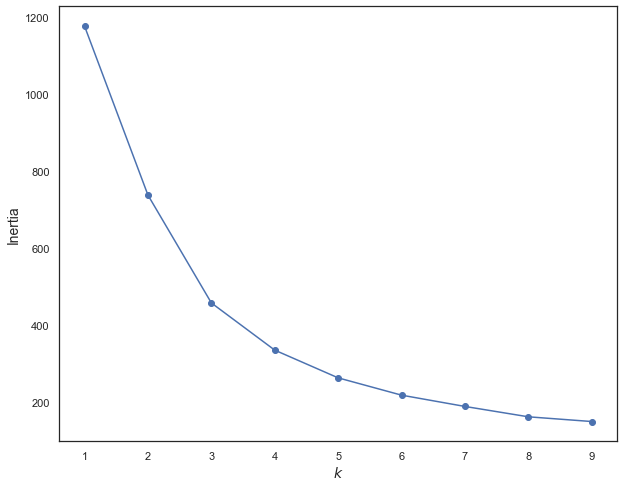

In [11]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [12]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [13]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [14]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [15]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='hsv')
    plt.show()

{-1: 136, 0: 30, 1: 48, 2: 30, 3: 15, 4: 39, 5: 19, 6: 25, 7: 14, 8: 7, 9: 21, 10: 8, 11: 10}


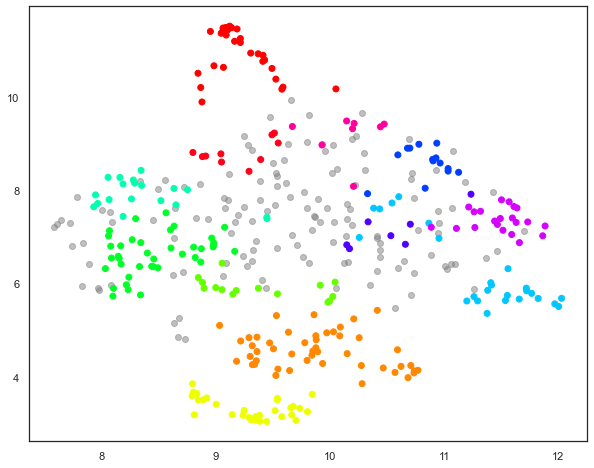

In [16]:
plot()

In [17]:
len(cluster)

402

In [18]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [19]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,new way learning well and well every day who k...
1,0,just finish film another quest with mindvalley...
2,1,absolutely correct same always love glad cross...
3,2,thank for the comment your alley thank you nee...
4,3,omg yesss that too when annular solar eclipse ...
5,4,what reality transurfe exactly mess with mind ...
6,5,chaos nothing more than your next level come g...
7,6,subscribe youtube because your ad be suck the ...
8,7,lucid dreaming the topic this week masterclass...
9,8,sulaiman launch podcast last year with the goa...


In [20]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 11 	 cluster 12 	 similarity: 0.6396
cluster 8 	 cluster 11 	 similarity: 0.5729
cluster 8 	 cluster 12 	 similarity: 0.5119
cluster 6 	 cluster 7 	 similarity: 0.4773
cluster 2 	 cluster 10 	 similarity: 0.4734
cluster 1 	 cluster 3 	 similarity: 0.4462
cluster 2 	 cluster 6 	 similarity: 0.4377
cluster 6 	 cluster 8 	 similarity: 0.4281
cluster 1 	 cluster 8 	 similarity: 0.4216
cluster 5 	 cluster 6 	 similarity: 0.4210
cluster 4 	 cluster 6 	 similarity: 0.4206
cluster 4 	 cluster 10 	 similarity: 0.4169
cluster 1 	 cluster 6 	 similarity: 0.4119
cluster 9 	 cluster 10 	 similarity: 0.4034
cluster 2 	 cluster 3 	 similarity: 0.4025
cluster 7 	 cluster 10 	 similarity: 0.4015
cluster 4 	 cluster 8 	 similarity: 0.3891
cluster 6 	 cluster 9 	 similarity: 0.3860
cluster 1 	 cluster 11 	 similarity: 0.3854
cluster 1 	 cluster 12 	 similarity: 0.3833
cluster 8 	 cluster 10 	 similarity: 0.3700
cluster 1 	 cluster 10 	 similarity: 0.3679
cluster 1 	 cluster 2 	

In [21]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1



Wall time: 24 ms


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

,cluster,comments
0,-1,new way learning well and well every day who k...
1,0,just finish film another quest with mindvalley...
2,1,absolutely correct same always love glad cross...
3,3,omg yesss that too when annular solar eclipse ...
4,4,what reality transurfe exactly mess with mind ...
5,8,sulaiman launch podcast last year with the goa...


In [23]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 1 	 cluster 2 	 similarity: 0.3665
cluster 1 	 cluster 3 	 similarity: 0.3631
cluster 1 	 cluster 5 	 similarity: 0.3379
cluster 2 	 cluster 5 	 similarity: 0.3218
cluster 2 	 cluster 3 	 similarity: 0.3165
cluster 3 	 cluster 5 	 similarity: 0.3052
cluster 1 	 cluster 4 	 similarity: 0.2744
cluster 2 	 cluster 4 	 similarity: 0.2029
cluster 3 	 cluster 4 	 similarity: 0.1929
cluster 4 	 cluster 5 	 similarity: 0.0989
Wall time: 1.41 s


In [24]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1

Wall time: 999 µs


In [25]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [26]:
labeled_docs

,cluster,comments
0,-1,new way learning well and well every day who k...
1,0,just finish film another quest with mindvalley...
2,1,absolutely correct same always love glad cross...
3,3,omg yesss that too when annular solar eclipse ...
4,4,what reality transurfe exactly mess with mind ...
5,8,sulaiman launch podcast last year with the goa...


In [27]:
%%time
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('awesome quest', 0.4558), ('routine quest', 0.443), ('break quest', 0.4244), ('day quest', 0.4232), ('aim finish', 0.4186), ('embark quest', 0.4177), ('reading quest', 0.4162), ('begin tomorrow', 0.4158), ('dream quest', 0.413), ('mindvalley complete', 0.4094)]
   Bigram Cluster 2: 
[('cross path', 0.447), ('cross lovely', 0.4206), ('rock love', 0.4029), ('yes try', 0.3951), ('love hear', 0.3828), ('think leap', 0.3803), ('love quote', 0.3799), ('nico try', 0.3754), ('hey adrienne', 0.3753), ('glad cross', 0.3741)]
   Bigram Cluster 3: 
[('read book', 0.4806), ('worth read', 0.467), ('watch read', 0.4458), ('book equally', 0.4432), ('eclipse occur', 0.437), ('unattainable book', 0.4335), ('try read', 0.4273), ('read lot', 0.4148), ('recommend reading', 0.4047), ('new book', 0.4046)]
   Bigram Cluster 4: 
[('prove mind', 0.4557), ('mess mind', 0.4237), ('extraordinary mind', 0.4208), ('state mind', 0.4093), ('level mind', 0.3894), ('mind stop', 0.389), ('lucid gu

In [28]:
%%time
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('finish', 0.3762), ('tomorrow', 0.3357), ('begin', 0.3286), ('complete', 0.3264), ('achieve', 0.3111), ('follow', 0.305), ('start', 0.304), ('luck', 0.3024), ('week', 0.3), ('end', 0.2935)]
   Unigram Cluster 2: 
[('cross', 0.4228), ('twitter', 0.3803), ('try', 0.3643), ('rock', 0.333), ('agree', 0.332), ('facebook', 0.3269), ('adrienne', 0.3208), ('true', 0.3126), ('check', 0.3096), ('enjoy', 0.3016)]
   Unigram Cluster 3: 
[('eclipse', 0.3842), ('book', 0.3428), ('read', 0.3264), ('fascinating', 0.3189), ('reading', 0.3004), ('expensive', 0.2901), ('premium', 0.2662), ('watch', 0.2605), ('burn', 0.2516), ('annular', 0.2503)]
   Unigram Cluster 4: 
[('mind', 0.3186), ('guy', 0.3003), ('reality', 0.2845), ('think', 0.2735), ('billionarie', 0.2469), ('vision', 0.2354), ('brain', 0.2319), ('visione', 0.2299), ('divine', 0.2274), ('consciousness', 0.2274)]
   Unigram Cluster 5: 
[('startup', 0.2983), ('podcast', 0.2964), ('launch', 0.2728), ('speak', 0.2698), ('di

In [29]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['finish', 'tomorrow', 'begin', 'complete', 'achieve', 'follow', 'start', 'luck', 'week', 'end', 'awesome quest', 'routine quest', 'break quest', 'day quest', 'aim finish', 'embark quest', 'reading quest', 'begin tomorrow', 'dream quest', 'mindvalley complete']
   Cluster 2: 
['cross', 'twitter', 'try', 'rock', 'agree', 'facebook', 'adrienne', 'true', 'check', 'enjoy', 'cross path', 'cross lovely', 'rock love', 'yes try', 'love hear', 'think leap', 'love quote', 'nico try', 'hey adrienne', 'glad cross']
   Cluster 3: 
['eclipse', 'book', 'read', 'fascinating', 'reading', 'expensive', 'premium', 'watch', 'burn', 'annular', 'read book', 'worth read', 'watch read', 'book equally', 'eclipse occur', 'unattainable book', 'try read', 'read lot', 'recommend reading', 'new book']
   Cluster 4: 
['mind', 'guy', 'reality', 'think', 'billionarie', 'vision', 'brain', 'visione', 'divine', 'consciousness', 'prove mind', 'mess mind', 'extraordinary mind', 'state mind', 'level mind', 'mi

In [30]:
end = time.time()
print(end - start)

131.41869735717773
